In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/project_dataset_1/"
IMG_SIZE = 224  
BATCH_SIZE = 32
EPOCHS = 30
CLASS_NAMES = ['no', 'yes']

In [ ]:
def create_image_dataframe(data_path):
    image_paths = []
    labels = []

    for class_name in CLASS_NAMES:
        class_dir = os.path.join(data_path, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            image_paths.append(img_path)
            labels.append(class_name)

    return pd.DataFrame({'filepath': image_paths, 'label': labels})

df = create_image_dataframe(DATA_PATH)

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
def create_datagen(preprocess_input, augmentation=False):
    if augmentation:
        return ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.9, 1.1]
        )
    else:
        return ImageDataGenerator(preprocessing_function=preprocess_input)

preprocess_input = applications.densenet.preprocess_input

train_datagen = create_datagen(preprocess_input, augmentation=True)
val_datagen = create_datagen(preprocess_input)
test_datagen = create_datagen(preprocess_input)

def create_flow(datagen, dataframe, shuffle=False):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='filepath',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=shuffle,
        classes=CLASS_NAMES
    )

train_generator = create_flow(train_datagen, train_df, shuffle=True)
val_generator = create_flow(val_datagen, val_df)
test_generator = create_flow(test_datagen, test_df)

Found 177 validated image filenames belonging to 2 classes.
Found 38 validated image filenames belonging to 2 classes.
Found 38 validated image filenames belonging to 2 classes.


In [ ]:
def create_densenet121_model():
    base_model = applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False  

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
    return model

model = create_densenet121_model()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_densenet121.h5', save_best_only=True),
    callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5671 - loss: 1.0220 - precision: 0.6608 - recall: 0.7070

6/6 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step - accuracy: 0.5733 - loss: 1.0076 - precision: 0.6601 - recall: 0.7144 - val_accuracy: 0.5526 - val_loss: 0.6832 - val_precision: 1.0000 - val_recall: 0.2917 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6059 - loss: 0.6993 - precision: 0.7438 - recall: 0.5210

6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - accuracy: 0.6170 - loss: 0.6848 - precision: 0.7469 - recall: 0.5457 - val_accuracy: 0.8158 - val_loss: 0.4274 - val_precision: 0.7742 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7471 - loss: 0.4947 - precision: 0.7591 - recall: 0.8862

6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.7477 - loss: 0.4950 - precision: 0.7629 - recall: 0.8760 - val_accuracy: 0.8158 - val_loss: 0.4269 - val_precision: 1.0000 - val_recall: 0.7083 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7925 - loss: 0.4028 - precision: 0.8437 - recall: 0.7918

6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.7890 - loss: 0.4102 - precision: 0.8369 - recall: 0.7978 - val_accuracy: 0.8684 - val_loss: 0.2867 - val_precision: 0.8276 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step - accuracy: 0.7996 - loss: 0.4697 - precision: 0.8159 - recall: 0.8756 - val_accuracy: 0.7895 - val_loss: 0.3602 - val_precision: 0.9444 - val_recall: 0.7083 - learning_rate: 0.0010
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8661 - loss: 0.3254 - precision: 0.8970 - recall: 0.8885

6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.8642 - loss: 0.3280 - precision: 0.8916 - recall: 0.8912 - val_accuracy: 0.9474 - val_loss: 0.2125 - val_precision: 0.9583 - val_recall: 0.9583 - learning_rate: 0.0010
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.8125 - loss: 0.4792 - precision: 0.8038 - recall: 0.9223 - val_accuracy: 0.8684 - val_loss: 0.2903 - val_precision: 0.9524 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8550 - loss: 0.3879 - precision: 0.8993 - recall: 0.8636

6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.8540 - loss: 0.3862 - precision: 0.8964 - recall: 0.8646 - val_accuracy: 0.9474 - val_loss: 0.2105 - val_precision: 0.9583 - val_recall: 0.9583 - learning_rate: 0.0010
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.8799 - loss: 0.2627 - precision: 0.8799 - recall: 0.9396 - val_accuracy: 0.7632 - val_loss: 0.3421 - val_precision: 0.9412 - val_recall: 0.6667 - learning_rate: 0.0010
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.8771 - loss: 0.2938 - precision: 0.9248 - recall: 0.8710 - val_accuracy: 0.9211 - val_loss: 0.2128 - val_precision: 0.9200 - val_recall: 0.9583 - learning_rate: 0.0010
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 84s 7s/step - accuracy: 0.8660 - loss: 0.3346 - precision: 0.8612 - recall: 0.9299 - val_accuracy: 0.9211 - val_loss: 0.2690 - val_precision: 0.9565 - val_recall: 0.9167 - learning_rate: 0.0010
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.8577 - loss: 0.2932 - prec

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 818ms/step - accuracy: 0.8251 - loss: 0.3201 - precision: 0.8758 - recall: 0.8364

Test Accuracy: 0.8158
Test Loss: 0.3286
Precision: 0.8636
Recall: 0.8261
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step

Classification Report:
              precision    recall  f1-score   support

          no       0.75      0.80      0.77        15
         yes       0.86      0.83      0.84        23

    accuracy                           0.82        38
   macro avg       0.81      0.81      0.81        38
weighted avg       0.82      0.82      0.82        38



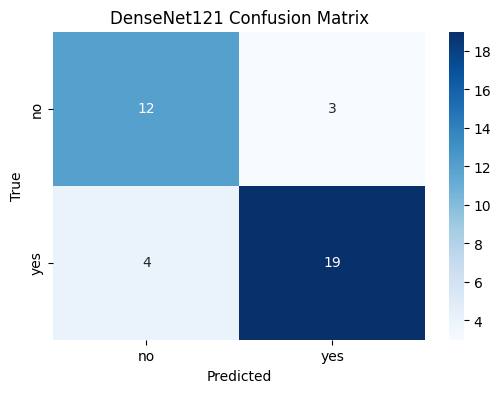

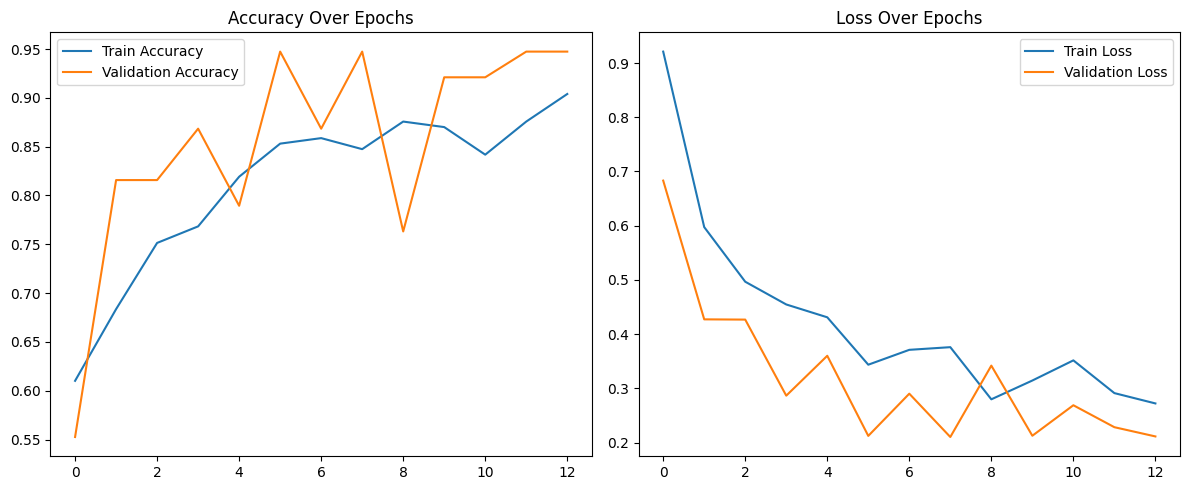

In [ ]:
model.load_weights('best_densenet121.h5')

test_results = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_results[1]:.4f}")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")

y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DenseNet121 Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()